In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=68e315e7839de5f67a222d5aa2ce55564ab39d8557921d7008b62997f153fd1c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [24]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


# Data Collection

In [25]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetches historical stock data for the given ticker symbol.

    :param ticker: Stock ticker symbol (e.g., "SPY" for S&P 500 ETF)
    :param start_date: Start date for data collection in 'YYYY-MM-DD' format
    :param end_date: End date for data collection in 'YYYY-MM-DD' format
    :return: DataFrame containing stock data
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

ticker = "^IXIC"
start_date = "2015-01-01"
end_date = "2023-01-01"
stock_data = fetch_stock_data(ticker, start_date, end_date)

stock_data.reset_index(inplace=True)
print("Dataframe Shape: ", stock_data.shape)
print("Null Value Present: ", stock_data.isnull().values.any())
stock_data.head()

[*********************100%***********************]  1 of 1 completed

Dataframe Shape:  (2014, 7)
Null Value Present:  False


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
0,2015-01-02 00:00:00+00:00,4726.810059,4726.810059,4777.009766,4698.109863,4760.240234,1435150000
1,2015-01-05 00:00:00+00:00,4652.569824,4652.569824,4702.770020,4641.459961,4700.339844,1794470000
2,2015-01-06 00:00:00+00:00,4592.740234,4592.740234,4667.330078,4567.589844,4666.850098,2167320000
3,2015-01-07 00:00:00+00:00,4650.470215,4650.470215,4652.720215,4613.899902,4626.839844,1957950000
4,2015-01-08 00:00:00+00:00,4736.189941,4736.189941,4741.379883,4688.020020,4689.540039,2105450000


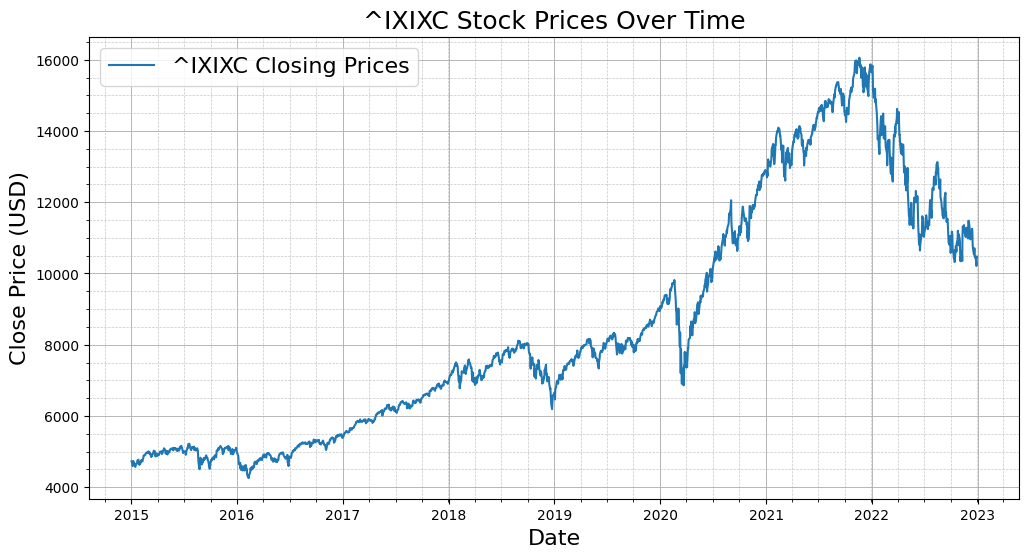

In [26]:
def visualize_stock_data(data, ticker):
    """
    Visualizes the stock data for a given ticker.

    :param data: DataFrame containing stock data with 'Date' as an index and columns like 'Close'.
    :param ticker: Stock ticker symbol for the title.
    """
    plt.figure(figsize=(12, 6))
    fontsize = 18
    plt.plot(data['Date'], data['Close'], label=f'{ticker} Closing Prices', linewidth=1.5)
    plt.title(f'{ticker} Stock Prices Over Time', fontsize=fontsize)
    plt.xlabel('Date', fontsize=fontsize-2)
    plt.ylabel('Close Price (USD)', fontsize=fontsize-2)
    plt.grid(visible=True, which='major', linestyle='-', linewidth=0.7, alpha=0.9)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=fontsize-2)
    plt.show()

# Visualize the stock data
visualize_stock_data(stock_data, ticker="^IXIXC")

# Data Preprocessing

## Targets

In [27]:
def preprocess_stock_data(data_org):
    """
    Preprocess the stock data for model training.
    - Handles missing values
    - Adds target labels for trend prediction and price prediction
    """
    # Make deep copy
    data = data_org.copy(deep=True)

    # Drop rows with missing values (if any)
    data = data.dropna().reset_index(drop=True)

    # Create a target for trend prediction: 1 if next day's close is higher, else 0
    # data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    # Add target for price prediction: next 5 day's avg close price
    # data['Next_Close'] = data['Close'].shift(-1)
    data['Target'] = data['Close'].rolling(window=5, min_periods=1).mean().shift(-5)

    # Remove the last row (target values will be NaN)
    data = data.iloc[:-1]

    return data

# Preprocess data
preprocessed_stock_data = preprocess_stock_data(stock_data)
preprocessed_stock_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,Target
Ticker,,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,
0,2015-01-02 00:00:00+00:00,4726.810059,4726.810059,4777.009766,4698.109863,4760.240234,1435150000,4667.208008
1,2015-01-05 00:00:00+00:00,4652.569824,4652.569824,4702.770020,4641.459961,4700.339844,1794470000,4669.636035
2,2015-01-06 00:00:00+00:00,4592.740234,4592.740234,4667.330078,4567.589844,4666.850098,2167320000,4683.387988
3,2015-01-07 00:00:00+00:00,4650.470215,4650.470215,4652.720215,4613.899902,4626.839844,1957950000,4681.157910
4,2015-01-08 00:00:00+00:00,4736.189941,4736.189941,4741.379883,4688.020020,4689.540039,2105450000,4648.083887


## Feature Engineering

In [28]:
def add_features(data_org):
    """
    Adds features for stock prediction.
    # - Lag features: Previous 10 closing prices
    - Technical indicators: RSI, MA_10, MA_20, MACD, KAMA, Bollinger_Upper, BOlinger_Lower, Volatility
    :param data: DataFrame containing stock data with a 'Close' column.
    :return: DataFrame with additional features.
    """
    # Make deep copy
    data = data_org.copy(deep=True)

    # Closing Prices
    close_series = data['Close'].squeeze()

    # Create lag features (previous 1-10 days closing prices)
    # for lag in range(1, 11):
    #     data[f'Lag_{lag}'] = close_series.shift(lag)

    # RSI (Relative Strength Index)
    data['RSI'] = ta.momentum.RSIIndicator(close_series, window=14).rsi()

    # Moving Averages (10-day, 20-day)
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    # MACD (Moving Average Convergence Divergence)
    macd = ta.trend.MACD(close_series)
    data['MACD'] = macd.macd()

    # KAMA (Kaufman's Adaptive Moving Average)
    data['KAMA'] = ta.momentum.KAMAIndicator(close_series).kama()

    # Add Bollinger Bands (upper and lower)
    bollinger = ta.volatility.BollingerBands(close_series, window=20, window_dev=2)
    data['Bollinger_Upper'] = bollinger.bollinger_hband()
    data['Bollinger_Lower'] = bollinger.bollinger_lband()

    # Add Volatility (Rolling standard deviation)
    data['Volatility'] = close_series.rolling(window=10).std()

    # Handle missing values caused by lagging/rolling
    # data = data.fillna(method='ffill').fillna(method='bfill')
    data = data.dropna().reset_index(drop=True)

    return data

# Add features to the preprocessed data
featured_stock_data = add_features(preprocessed_stock_data)
featured_stock_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,Target,RSI,MA_10,MA_20,MACD,KAMA,Bollinger_Upper,Bollinger_Lower,Volatility
Ticker,,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,,,,,,,,,
0,2015-02-09 00:00:00+00:00,4726.009766,4726.009766,4749.470215,4719.609863,4723.729980,1654680000,4847.908008,52.795601,4699.478076,4688.390991,9.165190,4606.385254,4794.203746,4582.578236,43.629049
1,2015-02-10 00:00:00+00:00,4787.640137,4787.640137,4793.270020,4737.120117,4754.629883,1773730000,4871.651953,58.772336,4710.092090,4694.537500,14.559408,4615.848542,4808.129494,4580.945506,51.049224
2,2015-02-11 00:00:00+00:00,4801.180176,4801.180176,4810.359863,4780.129883,4788.370117,1793630000,4896.355957,59.971452,4726.411084,4701.521509,19.699845,4636.975632,4823.029831,4580.013186,51.520736
3,2015-02-12 00:00:00+00:00,4857.609863,4857.609863,4857.609863,4823.569824,4828.080078,2075470000,4916.028027,64.593438,4743.831055,4712.436011,28.004267,4663.603686,4848.033474,4576.838548,63.437600
4,2015-02-13 00:00:00+00:00,4893.839844,4893.839844,4893.839844,4860.120117,4869.729980,1942240000,4929.454102,67.211196,4769.691016,4728.587012,37.081584,4720.802724,4869.702900,4587.471123,66.868243


## Create Sequencies


In [43]:
# Function to create sequences
def create_sequences(features, target, sequence_length, train_size=0.7, val_size=0.15):
    """
    Creates sequences of features and corresponding targets and splits them into train, validation, and test sets.

    Args:
        features (np.array): Feature matrix.
        target (np.array): Target array.
        sequence_length (int): Number of timesteps in each sequence.
        random_state (int): Random state for reproducibility.
        train_size (float): Proportion of data to use for training (0 < train_size < 1).
        val_size (float): Proportion of data to use for validation (0 < val_size < 1).

    Returns:
        X_train, X_val, X_test (np.array): Feature sequences for train, validation, and test sets.
        y_train, y_val, y_test (np.array): Targets for train, validation, and test sets.
    """
    if isinstance(features, pd.DataFrame):
        features = features.values

    valid_length = len(features) - sequence_length
    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length-1])

    # Convert to np.arrays
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    # if random_state is not None:
    #     np.random.seed(random_state)
    # indices = np.arange(X.shape[0])  # Create an array of indices
    # np.random.shuffle(indices)  # Shuffle indices
    # X = X[indices]
    # y = y[indices]

    # Calculate split indices
    total_samples = X.shape[0]
    train_end = int(train_size * total_samples)
    val_end = train_end + int(val_size * total_samples)

    # Split data into train, validation, and test sets
    X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

    # # Reshape
    # X_train = X_train.reshape(X_train.shape[0], sequence_length, len(feature_columns))
    # X_val = X_val.reshape(X_val.shape[0], sequence_length, len(feature_columns))
    # X_test = X_test.reshape(X_test.shape[0], sequence_length, len(feature_columns))

    return X_train, X_val, X_test, y_train, y_val, y_test


# Create datasets
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA',
            'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
          #  ['Open', 'High', 'Low', 'Close', 'Volume',
          #   'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA',
          #   'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
X_train, X_val, X_test, y_train, y_val, y_test = create_sequences(featured_stock_data[features].values, featured_stock_data['Target'].values, sequence_length)

# Display shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)


# Preproseccing Pipeline

In [45]:
def pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size):
    # Data Collection
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data.reset_index(inplace=True)

    # Data Visualization
    if visualizer:
        visualize_stock_data(stock_data, ticker)

    # Preprocess data
    preprocessed_stock_data = preprocess_stock_data(stock_data)

    #Feature Engineering
    featured_stock_data = add_features(preprocessed_stock_data)

    # Dataset Split
    # features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
    # features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
    X_train, X_val, X_test, y_train, y_val, y_test = create_sequences(featured_stock_data[features].values, featured_stock_data['Target'].values, sequence_length, train_size, val_size)

    return X_train, X_val, X_test, y_train, y_val, y_test


# Create datasets
ticker = '^IXIC'
start_date = '2015-01-01'
end_date = '2023-01-01'
visualizer = False
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0.7
val_size =0.15
X_train, X_val, X_test, y_train, y_val, y_test = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

# Display shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

[*********************100%***********************]  1 of 1 completed

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)


In [31]:
def pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size):
    # Data Collection
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data.reset_index(inplace=True)

    # Data Visualization
    if visualizer:
        visualize_stock_data(stock_data, ticker)

    # Preprocess data
    preprocessed_stock_data = preprocess_stock_data(stock_data)

    #Feature Engineering
    featured_stock_data = add_features(preprocessed_stock_data)

    # Dataset Split
    # features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
    # features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
    X_train, X_val, X_test, y_train, y_val, y_test = create_sequences(featured_stock_data[features].values, featured_stock_data['Target'].values, sequence_length)

    return X_train, X_val, X_test, y_train, y_val, y_test


# Create datasets
ticker = "^IXIC"
start_date = "2015-01-01"
end_date = "2023-01-01"
visualizer = False
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0.7
val_size =0.15
X_train, X_val, X_test, y_train, y_val, y_test = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

# Display shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

[*********************100%***********************]  1 of 1 completed

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)


# Model

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 30, 8, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  # x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  x = layers.GlobalAveragePooling1D()(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  # outputs = layers.Dense(n_outputs, activation='sigmoid')(x)
  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [33]:
transformer = build_transfromer(head_size=128, num_heads=8, ff_dim=128, num_trans_blocks=8, mlp_units=[256, 128, 64, 32], mlp_dropout=0.10, dropout=0.10, attention_axes=None,  epsilon = 1e-6, kernel_size=1)

In [34]:
transformer.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_32    │ (None, 30, 8)          │             16 │ input_layer_2[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_16   │ (None, 30, 8)          │         35,848 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 30, 8)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 30, 8)          │              0 │ dropout_57[0][0],      │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_33    │ (None, 30, 8)          │             16 │ add_32[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 30, 128)        │          1,152 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_58 (Dropout)      │ (None, 30, 128)        │              0 │ conv1d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 30, 8)          │          1,032 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_33 (Add)              │ (None, 30, 8)          │              0 │ conv1d_33[0][0],       │
│                           │                        │                │ add_32[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_34    │ (None, 30, 8)          │             16 │ add_33[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_17   │ (None, 30, 8)          │         35,848 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_60 (Dropout)      │ (None, 30, 8)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_34 (Add)              │ (None, 30, 8)          │              0 │ dropout_60[0][0],      │
│                           │                        │                │ add_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_35    │ (None, 30, 8)          │             16 │ add_34[0][0]           │
│ (LayerNormalization) 

 Total params: 350,081 (1.34 MB)

 Trainable params: 350,081 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [35]:
def model_train(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout, attention_axes, epsilon, kernel_size, learning_rate_start, learning_rate_stop, patience_lr, patience_es, batch_size, epochs, save_name, X_train, y_train, X_val, y_val):
  # Build and compile the model
  model = build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout, attention_axes, epsilon, kernel_size)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_start),
      loss="mse",
      metrics=["mae", "mape"]
  )

  # Define callbacks
  early_stopping = EarlyStopping(
      monitor="val_loss",        # Monitors the validation loss
      patience=patience_es,      # Stops training if no improvement for 50 consecutive epochs
      restore_best_weights=True  # Restores the best weights after stopping
  )

  reduce_lr = ReduceLROnPlateau(
      monitor="val_loss",       # Monitors the validation loss
      factor=0.1,               # Reduces learning rate by half
      patience=patience_lr,     # Reduces learning rate if no improvement for 3 epochs
      min_lr=learning_rate_stop # Sets the minimum learning rate
  )
  # Train the model
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      batch_size=batch_size,
      epochs=epochs,
      callbacks=[early_stopping, reduce_lr]
  )

  # Save the model
  model.save(f'{save_name}')

  return model, history

In [ ]:
# Model Params
head_size = 128
num_heads = 8
ff_dim = 128
num_trans_blocks = 8
mlp_units = [256, 128, 64, 32]
dropout = 0.1
mlp_dropout = 0.1
attention_axes = None
kernel_size = 1
epsilon = 1e-6

# Training Params
learning_rate_start = 1e-3
learning_rate_stop = 1e-10
patience_lr = 20
patience_es = 50
batch_size = 32
epochs = 200


save_name = 'ixic_model.h5'

model_ixic, history_ixic = model_train(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout,
                                       attention_axes, epsilon, kernel_size, learning_rate_start, learning_rate_stop,
                                       patience_lr, patience_es, batch_size, epochs, save_name, X_train, y_train, X_val, y_val)


Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 573ms/step - loss: 15296509.0000 - mae: 3201.0615 - mape: 48.4141 - val_loss: 195755.8750 - val_mae: 372.0858 - val_mape: 2.8219 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2110304.5000 - mae: 1113.4558 - mape: 16.0122 - val_loss: 227428.1094 - val_mae: 411.4363 - val_mape: 3.0963 - learning_rate: 0.0010
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1460960.3750 - mae: 934.0330 - mape: 14.0174 - val_loss: 1100851.2500 - val_mae: 961.6599 - val_mape: 7.1639 - learning_rate: 0.0010
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1316898.7500 - mae: 886.5594 - mape: 13.2318 - val_loss: 3193887.7500 - val_mae: 1736.9923 - val_mape: 12.9501 - learning_rate: 0.0010
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1223744.1250 - mae: 873.2415 - mape: 13.0086 - val_loss: 870538.5000 - val_mae: 835.8921 - val_mape: 6.2210 - learning_rate: 0.0010
Epoch 6/200
43/43 ━━━━━━━━━━━━━

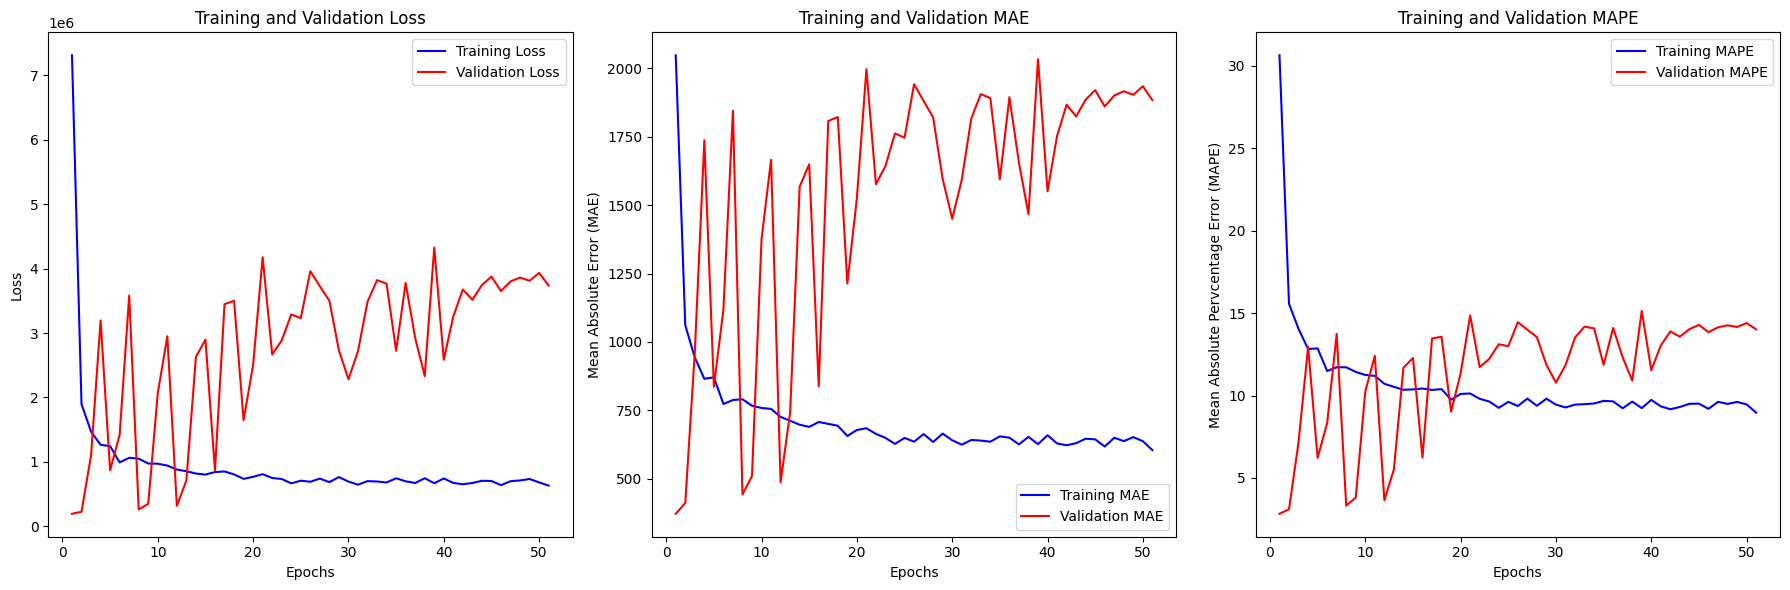

In [37]:
# Plot learning curves for training and validation metrics
def plot_learning_curves(history):
    # Extract metrics from the history
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    mae = history.history.get('mae', [])
    val_mae = history.history.get('val_mae', [])
    mape = history.history.get('mape', [])
    val_mape = history.history.get('val_mape', [])

    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs, mae, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()

    # Plot training and validation MAE
    plt.subplot(1, 3, 3)
    plt.plot(epochs, mape, 'b-', label='Training MAPE')
    plt.plot(epochs, val_mape, 'r-', label='Validation MAPE')
    plt.title('Training and Validation MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Pervcentage Error (MAPE)')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_learning_curves(history_ixic)

# Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1116094.7500 - mae: 868.2120 - mape: 6.6016
Test Loss: 1198204.25, Test MAE: 905.469482421875, Test MAPE: 7.327520370483398
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
R² Score: 0.5920
Mean Absolute Error (MAE): 905.4695
Mean Squared Error (MSE): 1198204.2603
Root Mean Squared Error (RMSE): 1094.6252
Mean Absolute Percentage Error (MAPE): 7.33 %
Directional Percentage of Accuracy (DPA): 44.71 %


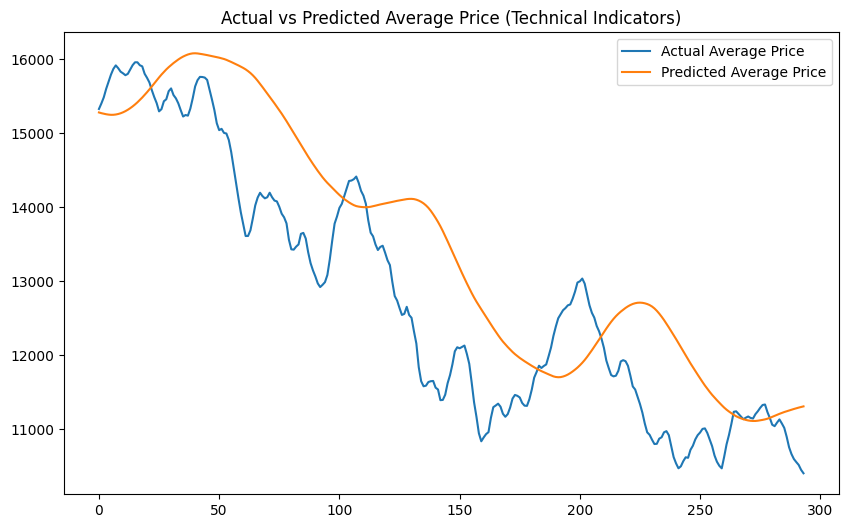

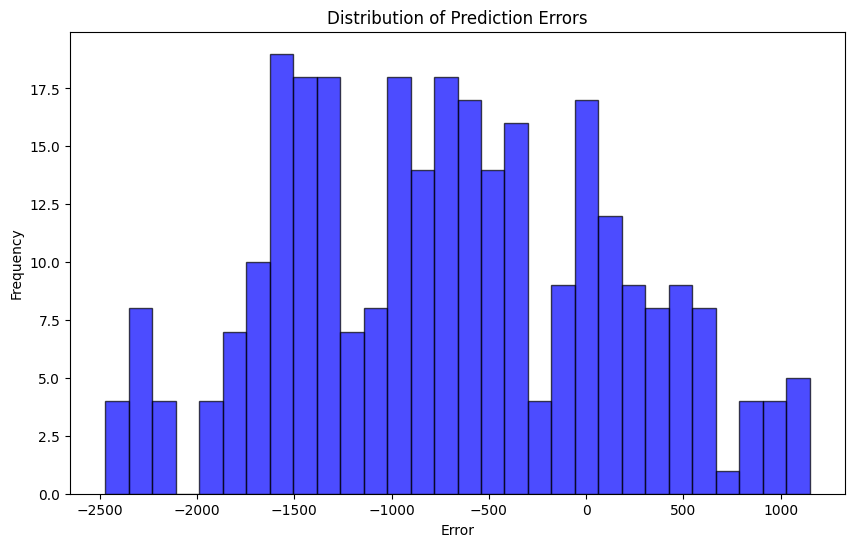

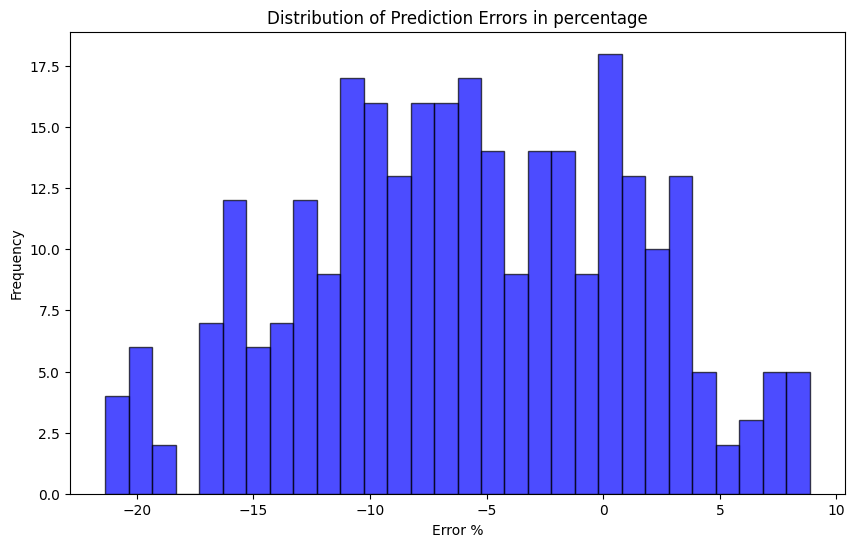

In [38]:
def model_eval(model, X_test, y_test):
  # Evaluate the model
  test_loss, test_mae, test_mape = model.evaluate(X_test, y_test)
  print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MAPE: {test_mape}")

  y_pred = model.predict(X_test).flatten()

  # Evaluate predictions with additional metrics
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  real_direction = np.sign(np.diff(y_test))  # +1 for up, -1 for down, 0 for no change
  predicted_direction = np.sign(np.diff(y_pred))  # Same for predictions
  correct_directions = real_direction == predicted_direction # Compare the directions
  dpe = np.sum(correct_directions) / len(correct_directions) * 100 # Calculate Directional Percentage of Error (DPE)


  print(f"R² Score: {r2:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f} %")
  print(f"Directional Percentage of Accuracy (DPA): {dpe:.2f} %")


  # Visualize predictions vs actual
  plt.figure(figsize=(10, 6))
  plt.plot(y_test, label='Actual Average Price')
  plt.plot(y_pred, label='Predicted Average Price')
  plt.legend()
  plt.title("Actual vs Predicted Average Price (Technical Indicators)")
  plt.show()

  # Absolute error plotting
  errors = y_test - y_pred
  plt.figure(figsize=(10, 6))
  plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
  plt.title('Distribution of Prediction Errors')
  plt.xlabel('Error')
  plt.ylabel('Frequency')
  plt.show()

  # percentage error plotting
  errors = 100*(y_test - y_pred)/y_test
  plt.figure(figsize=(10, 6))
  plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
  plt.title('Distribution of Prediction Errors in percentage')
  plt.xlabel('Error %')
  plt.ylabel('Frequency')
  plt.show()


model_eval(model_ixic, X_test, y_test)

## Unseen Data (Different Period)

[*********************100%***********************]  1 of 1 completed

X_test shape: (399, 30, 8), y_test shape: (399,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 264646.7500 - mae: 422.3279 - mape: 3.0051


Test Loss: 325643.15625, Test MAE: 478.1744079589844, Test MAPE: 3.1676626205444336
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R² Score: 0.9125
Mean Absolute Error (MAE): 478.1743
Mean Squared Error (MSE): 325643.1412
Root Mean Squared Error (RMSE): 570.6515
Mean Absolute Percentage Error (MAPE): 3.17 %
Directional Percentage of Accuracy (DPA): 56.28 %


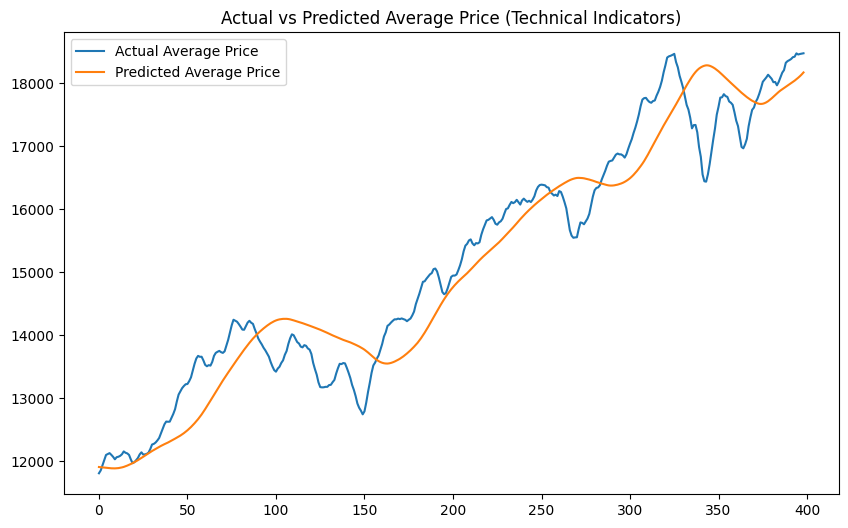

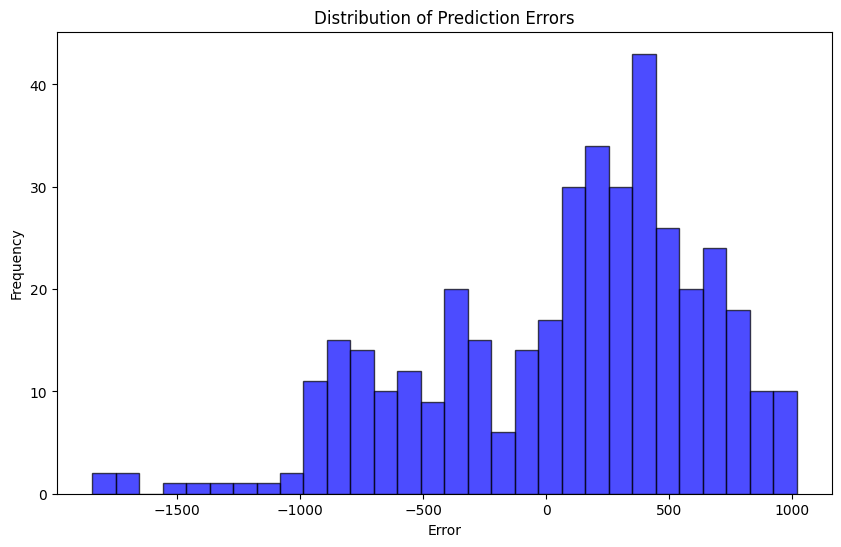

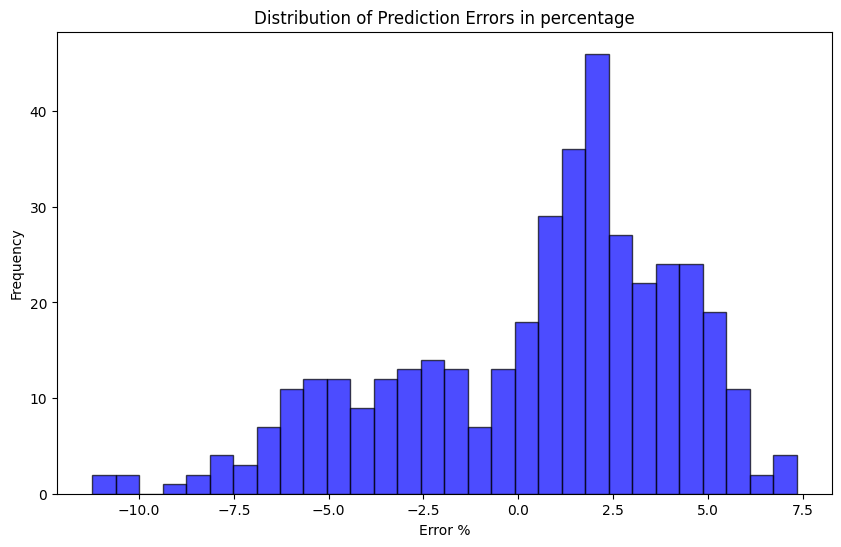

In [47]:
def model_eval_unseen(model, ticker, start_date, end_date, visualizer, features, sequence_length, train_size=0, val_size=0):
  # Create Unseen Dataset
  _, _, X_test_unseen, _, _, y_test_unseen = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

  # Display shapes for verification
  print(f"X_test shape: {X_test_unseen.shape}, y_test shape: {y_test_unseen.shape}")

  # Evaluation
  model_eval(model, X_test_unseen, y_test_unseen)


ticker = "^IXIC"
start_date = "2023-01-01"
end_date = "2024-10-30"
visualizer = False
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0
val_size = 0
model_eval_unseen(model_ixic, ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)




# NASDAQ (IXIC)

[*********************100%***********************]  1 of 1 completed

----- Create Datasets -----


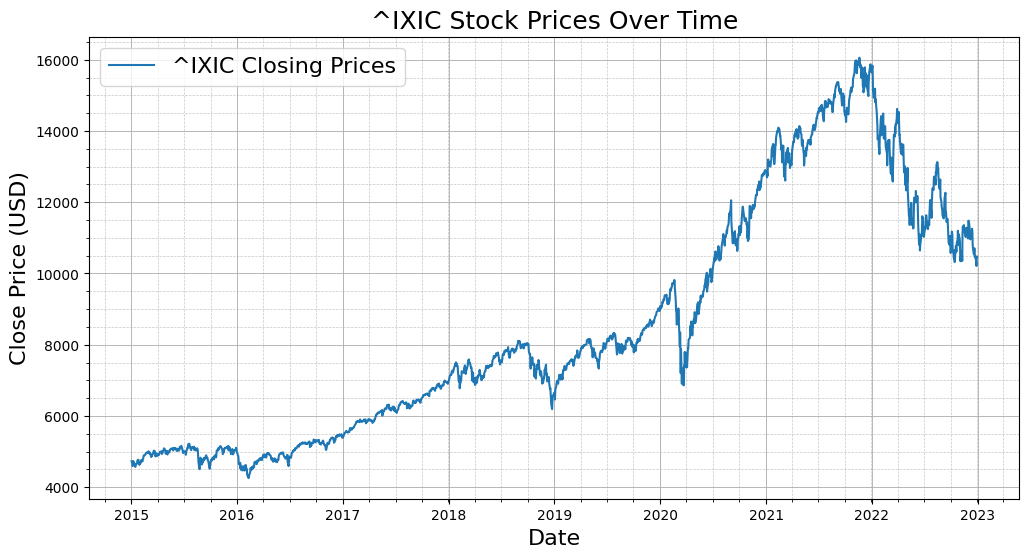

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)
----- Model Training -----
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 568ms/step - loss: 13251724.0000 - mae: 2883.1169 - mape: 43.5746 - val_loss: 2808702.0000 - val_mae: 1622.5607 - val_mape: 12.1052 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 1515033.6250 - mae: 963.6844 - mape: 14.2797 - val_loss: 338489.2500 - val_mae: 460.7466 - val_mape: 3.4788 - learning_rate: 0.0010
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1388684.6250 - mae: 902.3833 - mape: 13.3213 - val_loss: 518312.5312 - val_mae: 617.0975 - val_mape: 4.5977 - learning_rate: 0.0010
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1136120.7500 - mae: 830.2983 - mape: 12.4115 - val_loss: 2270714.0000 - val_mae: 1447.4949 - val_mape: 10.7922 - learning_rate: 0.0010
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18m

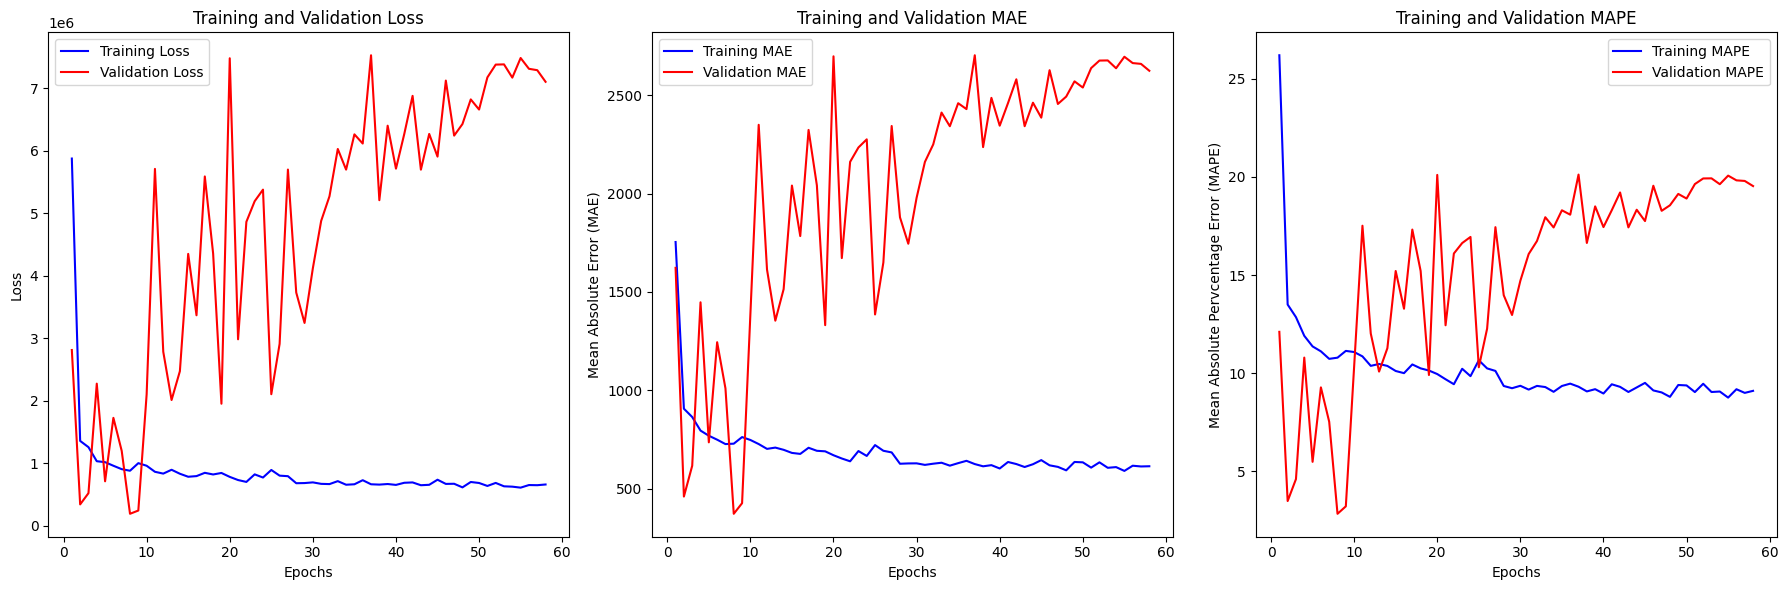

----- Evaluation -----
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 870990.8750 - mae: 784.1090 - mape: 5.9095
Test Loss: 928873.375, Test MAE: 805.2957763671875, Test MAPE: 6.480791091918945
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step
R² Score: 0.6837
Mean Absolute Error (MAE): 805.2958
Mean Squared Error (MSE): 928873.3463
Root Mean Squared Error (RMSE): 963.7808
Mean Absolute Percentage Error (MAPE): 6.48 %
Directional Percentage of Accuracy (DPA): 43.34 %


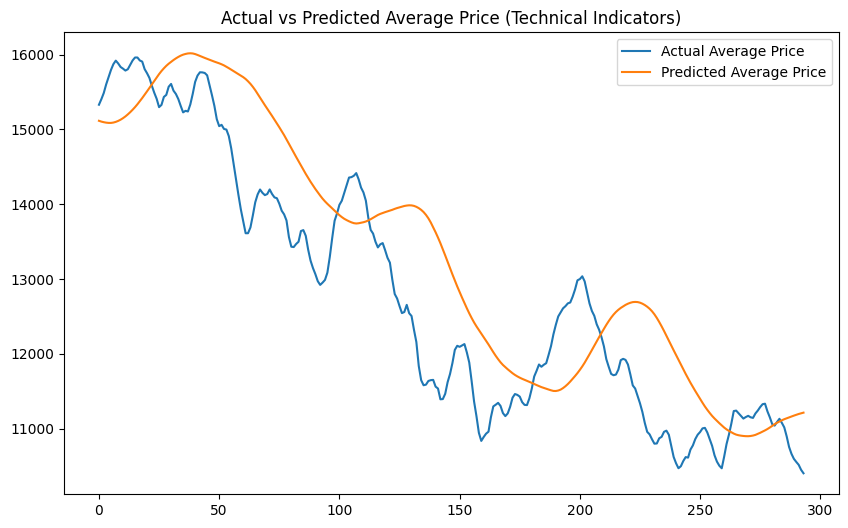

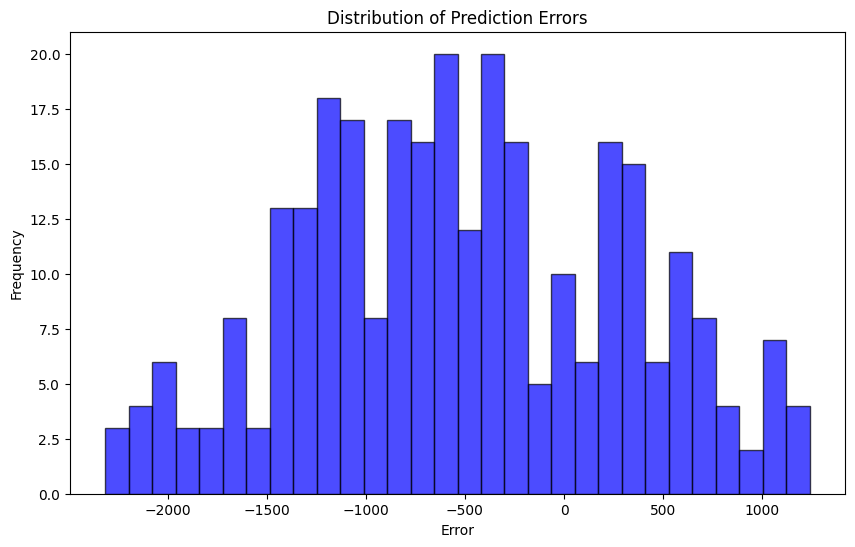

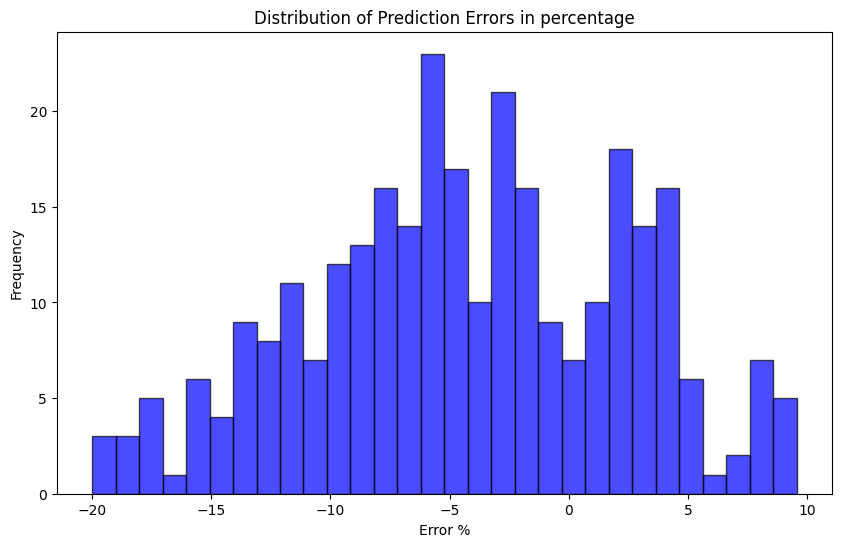

[*********************100%***********************]  1 of 1 completed

----- Evaluation (Different Period) -----
X_test shape: (399, 30, 8), y_test shape: (399,)
 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 211522.3750 - mae: 375.8557 - mape: 2.8054

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 245906.9688 - mae: 408.4684 - mape: 2.9118
Test Loss: 308783.3125, Test MAE: 462.6224670410156, Test MAPE: 3.0588746070861816
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
R² Score: 0.9171
Mean Absolute Error (MAE): 462.6224
Mean Squared Error (MSE): 308783.2765
Root Mean Squared Error (RMSE): 555.6827
Mean Absolute Percentage Error (MAPE): 3.06 %
Directional Percentage of Accuracy (DPA): 57.04 %


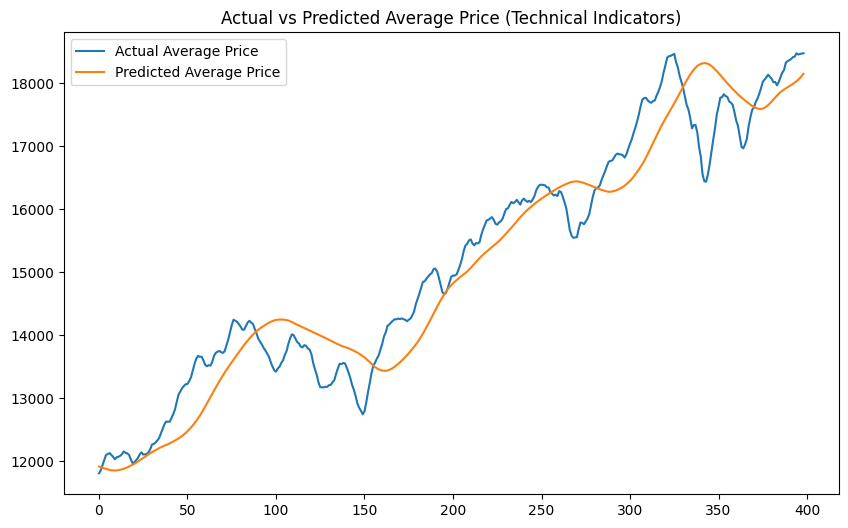

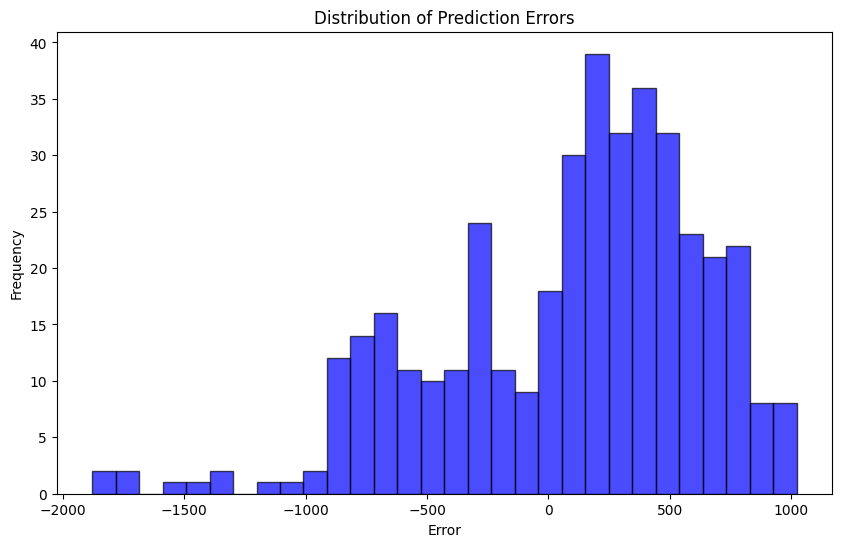

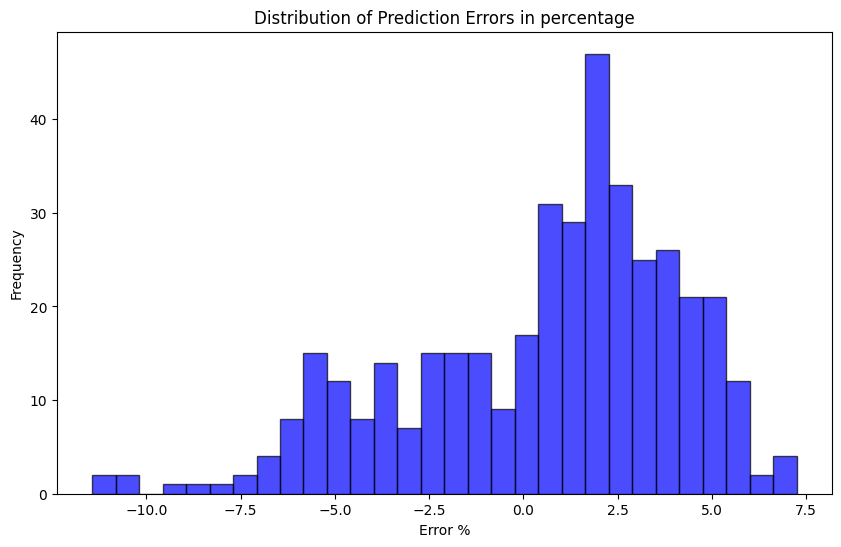

In [48]:
print('----- Create Datasets -----')
# Create datasets
ticker = '^IXIC'
start_date = '2015-01-01'
end_date = '2023-01-01'
visualizer = True
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0.7
val_size =0.15
X_train_ixic, X_val_ixic, X_test_ixic, y_train_ixic, y_val_ixic, y_test_ixic = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

# Display shapes for verification
print(f"X_train shape: {X_train_ixic.shape}, y_train shape: {y_train_ixic.shape}")
print(f"X_val shape: {X_val_ixic.shape}, y_val shape: {y_val_ixic.shape}")
print(f"X_test shape: {X_test_ixic.shape}, y_test shape: {y_test_ixic.shape}")

print('----- Model Training -----')
# Parameters for the model
head_size = 128
num_heads = 8
ff_dim = 128
num_trans_blocks = 8
mlp_units = [256, 128, 64, 32]
dropout = 0.1
mlp_dropout = 0.1
attention_axes = None
kernel_size = 1
epsilon = 1e-6
learning_rate_start = 1e-3
learning_rate_stop = 1e-10
patience_lr = 20
patience_es = 50
batch_size = 32
epochs = 200
save_name = 'ixic_model.h5'

model_ixic, history_ixic = model_train(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout,
                                       attention_axes, epsilon, kernel_size, learning_rate_start, learning_rate_stop,
                                       patience_lr, patience_es, batch_size, epochs, save_name, X_train_ixic, y_train_ixic, X_val_ixic, y_val_ixic)

plot_learning_curves(history_ixic)

print('----- Evaluation -----')
model_eval(model_ixic, X_test_ixic, y_test_ixic)

print('----- Evaluation (Different Period) -----')
# ticker = "^IXIC"
start_date_unseen = "2023-01-01"
end_date_unseen = "2024-10-30"
visualizer_unseen = False
# features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
# sequence_length = 30
train_size_unseen = 0
val_size_unseen = 0
model_eval_unseen(model_ixic, ticker, start_date_unseen, end_date_unseen, visualizer_unseen, features, sequence_length, train_size_unseen, val_size_unseen)

# S&P 500 (GSPC)

[*********************100%***********************]  1 of 1 completed

----- Create Datasets -----


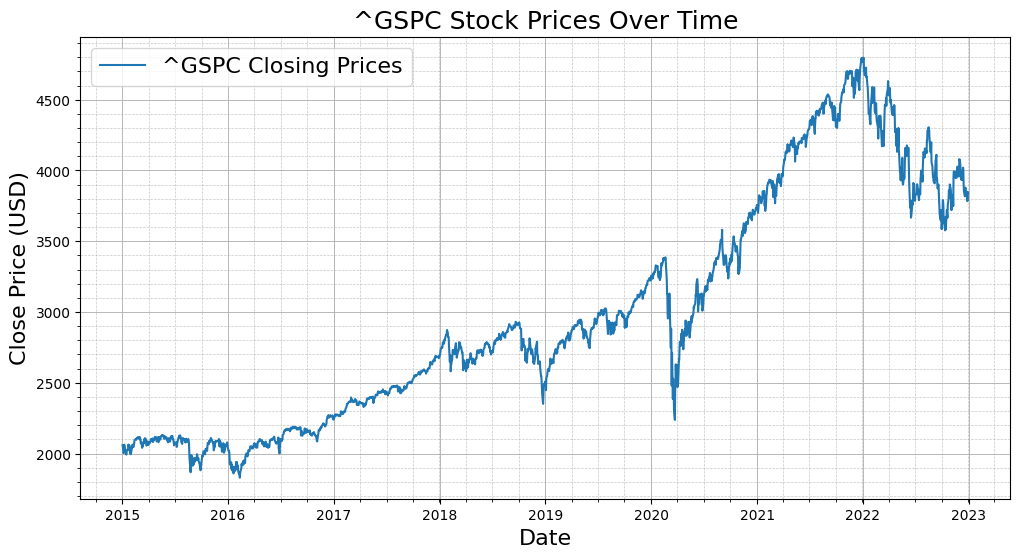

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)
----- Model Training -----
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 601ms/step - loss: 2515269.0000 - mae: 1276.8845 - mape: 50.2649 - val_loss: 133052.9531 - val_mae: 354.7254 - val_mape: 8.9050 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 288581.1562 - mae: 413.1746 - mape: 16.0536 - val_loss: 259956.6406 - val_mae: 502.2868 - val_mape: 12.6141 - learning_rate: 0.0010
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 221369.2500 - mae: 360.9532 - mape: 14.1685 - val_loss: 347478.9062 - val_mae: 582.5939 - val_mape: 14.6306 - learning_rate: 0.0010
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 166368.5625 - mae: 322.7143 - mape: 12.7598 - val_loss: 335592.5000 - val_mae: 572.3151 - val_mape: 14.3695 - learning_rate: 0.0010
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 

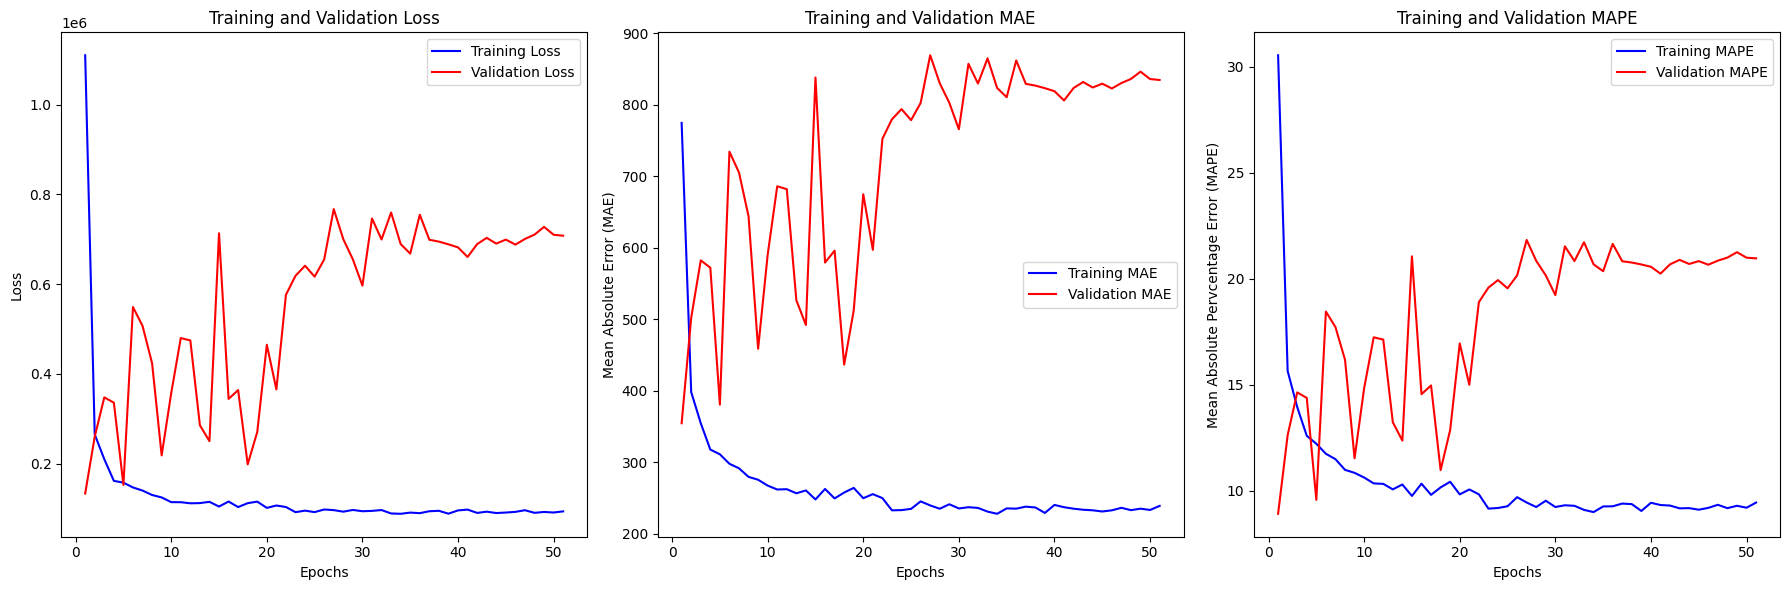

----- Evaluation -----
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 116370.7266 - mae: 295.2409 - mape: 6.6000
Test Loss: 101297.84375, Test MAE: 267.8874816894531, Test MAPE: 6.2882771492004395
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step
R² Score: 0.0915
Mean Absolute Error (MAE): 267.8875
Mean Squared Error (MSE): 101297.8473
Root Mean Squared Error (RMSE): 318.2732
Mean Absolute Percentage Error (MAPE): 6.29 %
Directional Percentage of Accuracy (DPA): 41.64 %


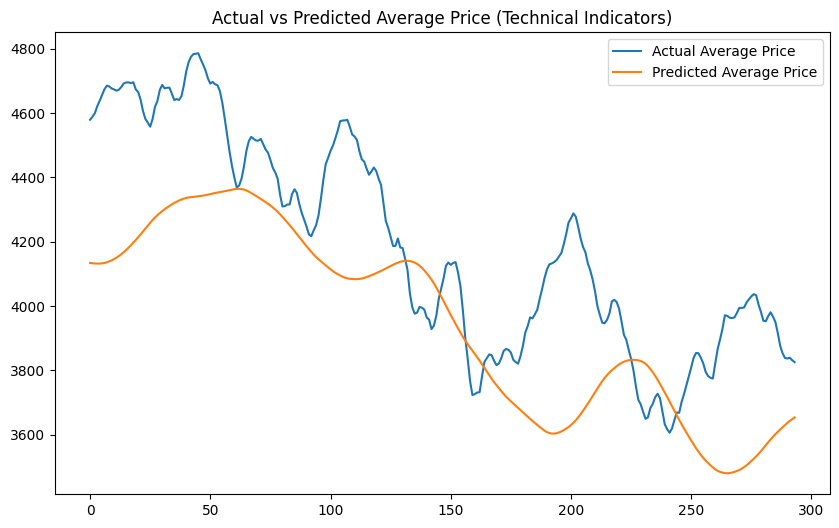

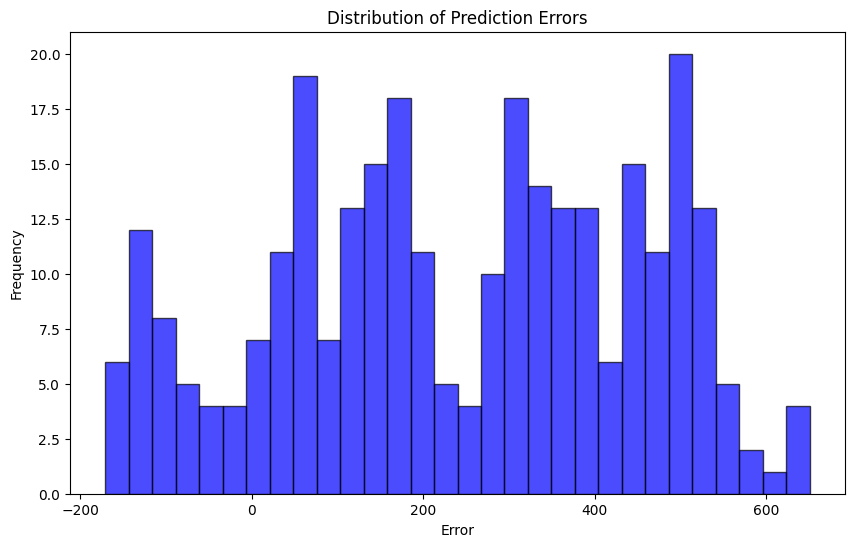

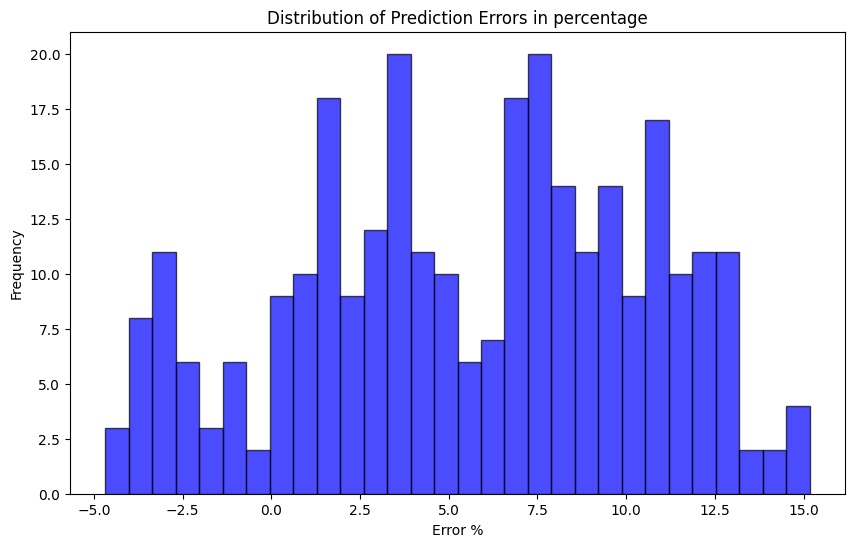

[*********************100%***********************]  1 of 1 completed

----- Evaluation (Different Period) -----
X_test shape: (399, 30, 8), y_test shape: (399,)
 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 156050.5312 - mae: 379.3174 - mape: 8.7468 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 172352.0156 - mae: 396.3337 - mape: 8.7501
Test Loss: 201811.890625, Test MAE: 428.1846923828125, Test MAPE: 8.764715194702148
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
R² Score: 0.2870
Mean Absolute Error (MAE): 428.1846
Mean Squared Error (MSE): 201811.8834
Root Mean Squared Error (RMSE): 449.2348
Mean Absolute Percentage Error (MAPE): 8.76 %
Directional Percentage of Accuracy (DPA): 59.55 %


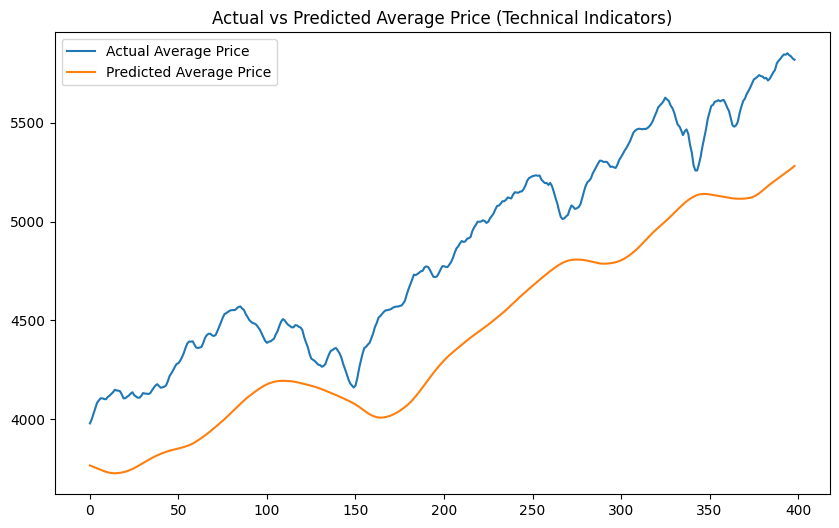

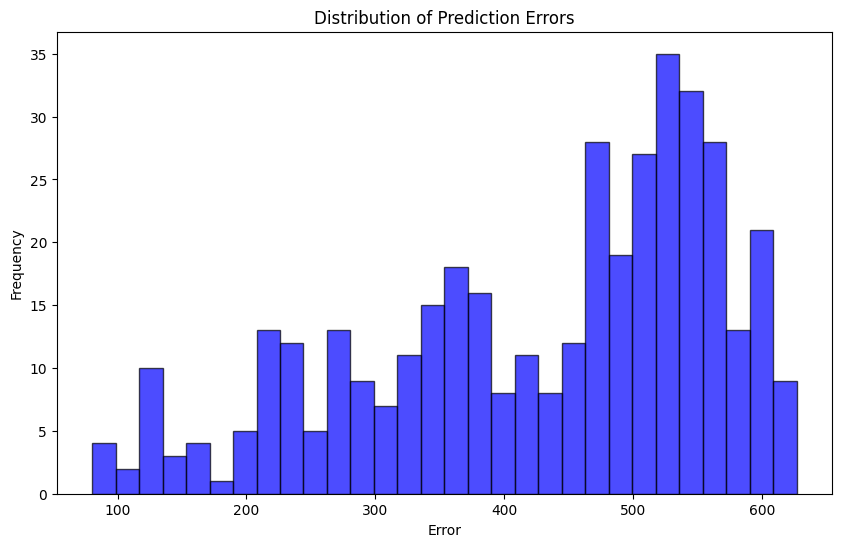

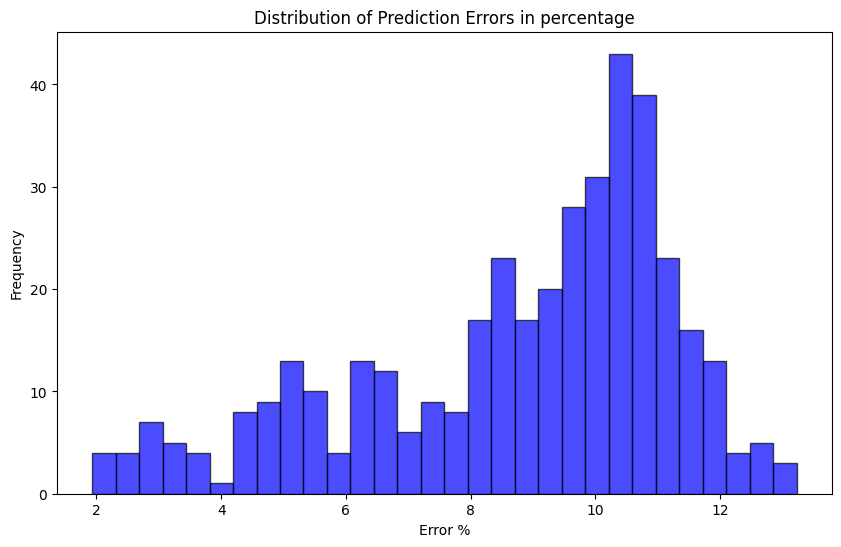

In [49]:
print('----- Create Datasets -----')
# Create datasets
ticker = '^GSPC'
start_date = '2015-01-01'
end_date = '2023-01-01'
visualizer = True
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0.7
val_size =0.15
X_train_gspc, X_val_gspc, X_test_gspc, y_train_gspc, y_val_gspc, y_test_gspc = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

# Display shapes for verification
print(f"X_train shape: {X_train_gspc.shape}, y_train shape: {y_train_gspc.shape}")
print(f"X_val shape: {X_val_gspc.shape}, y_val shape: {y_val_gspc.shape}")
print(f"X_test shape: {X_test_gspc.shape}, y_test shape: {y_test_gspc.shape}")

print('----- Model Training -----')
# Parameters for the model
head_size = 128
num_heads = 8
ff_dim = 128
num_trans_blocks = 8
mlp_units = [256, 128, 64, 32]
dropout = 0.1
mlp_dropout = 0.1
attention_axes = None
kernel_size = 1
epsilon = 1e-6
learning_rate_start = 1e-3
learning_rate_stop = 1e-10
patience_lr = 20
patience_es = 50
batch_size = 32
epochs = 200
save_name = 'gspc_model.h5'

model_gspc, history_gspc = model_train(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout,
                                       attention_axes, epsilon, kernel_size, learning_rate_start, learning_rate_stop,
                                       patience_lr, patience_es, batch_size, epochs, save_name, X_train_gspc, y_train_gspc, X_val_gspc, y_val_gspc)

plot_learning_curves(history_gspc)

print('----- Evaluation -----')
model_eval(model_gspc, X_test_gspc, y_test_gspc)

print('----- Evaluation (Different Period) -----')
# ticker = "^IXIC"
start_date_unseen = "2023-01-01"
end_date_unseen = "2024-10-30"
visualizer_unseen = False
# features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
# sequence_length = 30
train_size_unseen = 0
val_size_unseen = 0
model_eval_unseen(model_gspc, ticker, start_date_unseen, end_date_unseen, visualizer_unseen, features, sequence_length, train_size_unseen, val_size_unseen)

# Dow Jones (DJI)

[*********************100%***********************]  1 of 1 completed

----- Create Datasets -----


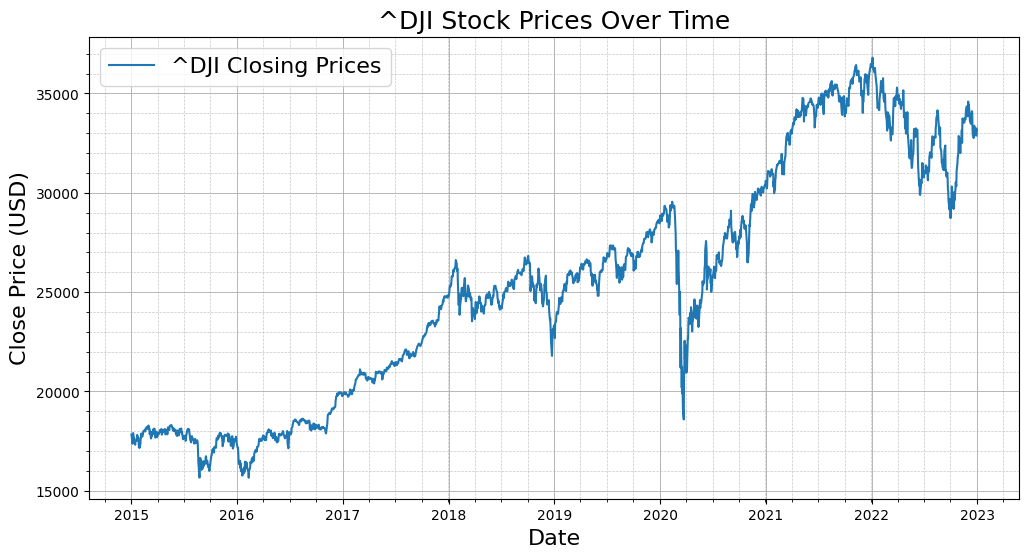

X_train shape: (1367, 30, 8), y_train shape: (1367,)
X_val shape: (293, 30, 8), y_val shape: (293,)
X_test shape: (294, 30, 8), y_test shape: (294,)
----- Model Training -----
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 584ms/step - loss: 186020144.0000 - mae: 11254.5283 - mape: 50.8248 - val_loss: 2485698.0000 - val_mae: 1421.2968 - val_mape: 4.4375 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 16833192.0000 - mae: 3193.8831 - mape: 14.3909 - val_loss: 18472776.0000 - val_mae: 4242.6538 - val_mape: 13.1881 - learning_rate: 0.0010
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16779730.0000 - mae: 3195.5115 - mape: 14.2310 - val_loss: 8225503.0000 - val_mae: 2784.1167 - val_mape: 8.6644 - learning_rate: 0.0010
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 13614903.0000 - mae: 2876.5393 - mape: 12.7884 - val_loss: 9509524.0000 - val_mae: 3006.1772 - val_mape: 9.3548 - learning_rate: 0.0010
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━

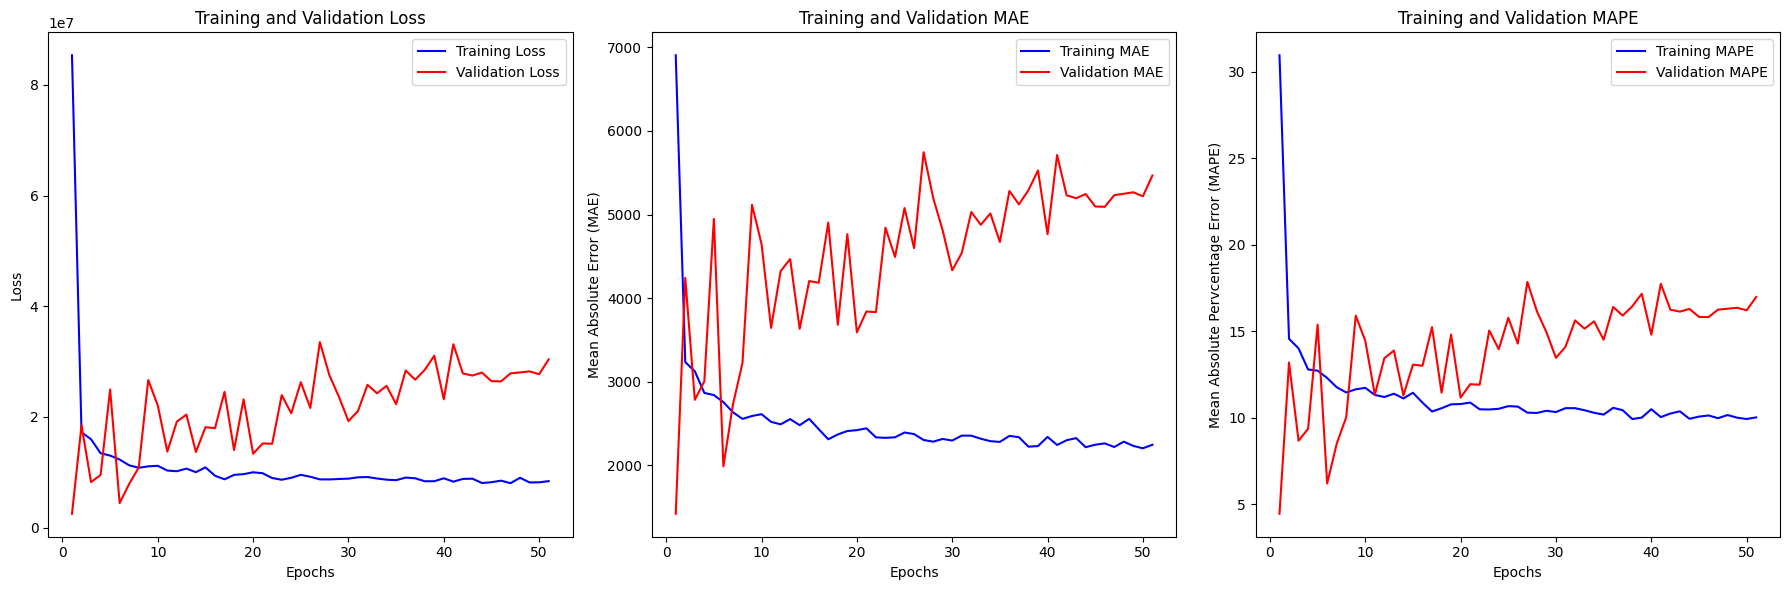

----- Evaluation -----
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 2069804.7500 - mae: 1184.0814 - mape: 3.4448
Test Loss: 2879889.75, Test MAE: 1358.3990478515625, Test MAPE: 4.073631763458252
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step
R² Score: 0.1850
Mean Absolute Error (MAE): 1358.3991
Mean Squared Error (MSE): 2879889.9013
Root Mean Squared Error (RMSE): 1697.0238
Mean Absolute Percentage Error (MAPE): 4.07 %
Directional Percentage of Accuracy (DPA): 41.64 %


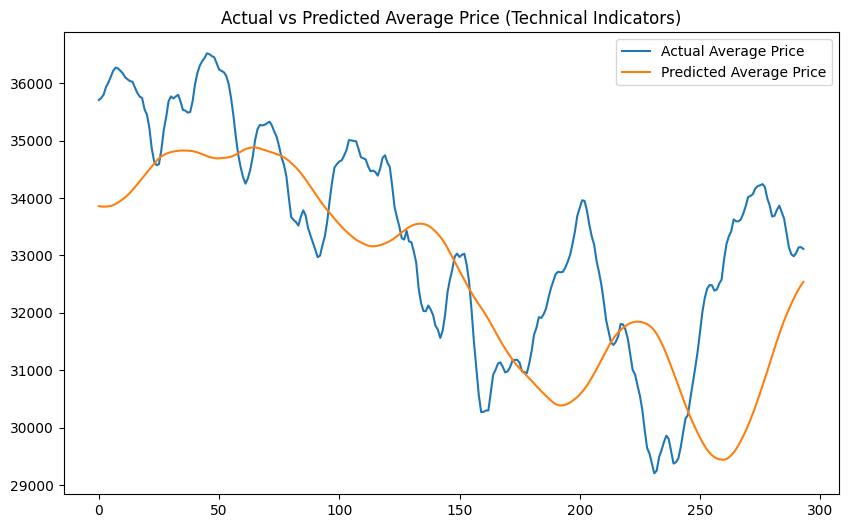

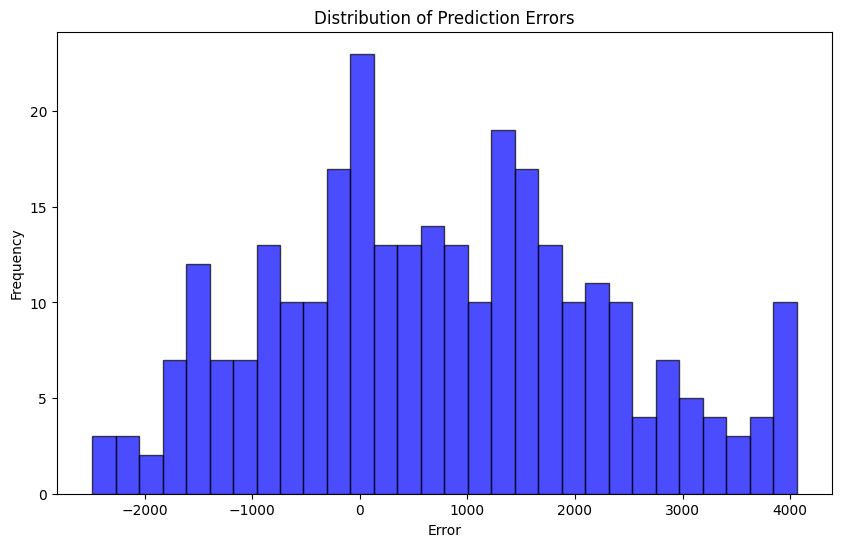

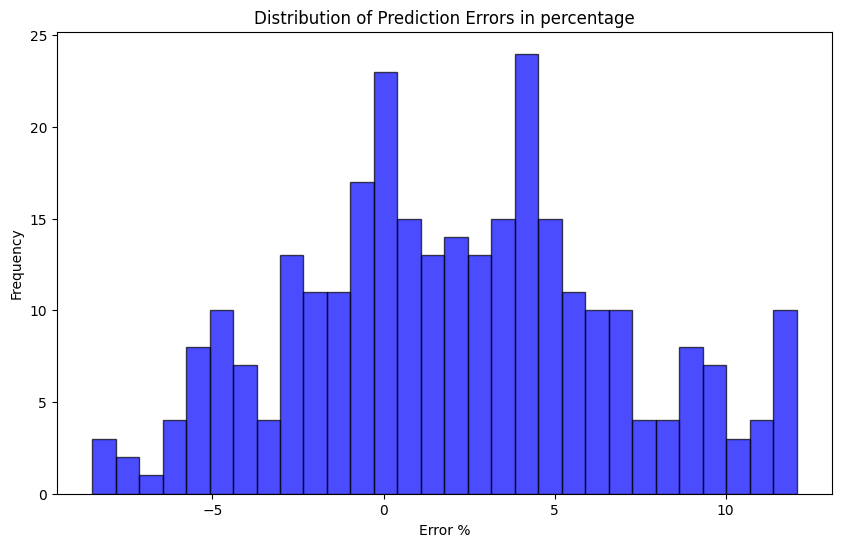

[*********************100%***********************]  1 of 1 completed

----- Evaluation (Different Period) -----
X_test shape: (399, 30, 8), y_test shape: (399,)
 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2266875.7500 - mae: 1298.0525 - mape: 3.7481 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2526156.2500 - mae: 1363.6993 - mape: 3.8231
Test Loss: 3011289.25, Test MAE: 1507.6173095703125, Test MAPE: 4.011054992675781
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
R² Score: 0.6478
Mean Absolute Error (MAE): 1507.6174
Mean Squared Error (MSE): 3011289.2601
Root Mean Squared Error (RMSE): 1735.3067
Mean Absolute Percentage Error (MAPE): 4.01 %
Directional Percentage of Accuracy (DPA): 53.77 %


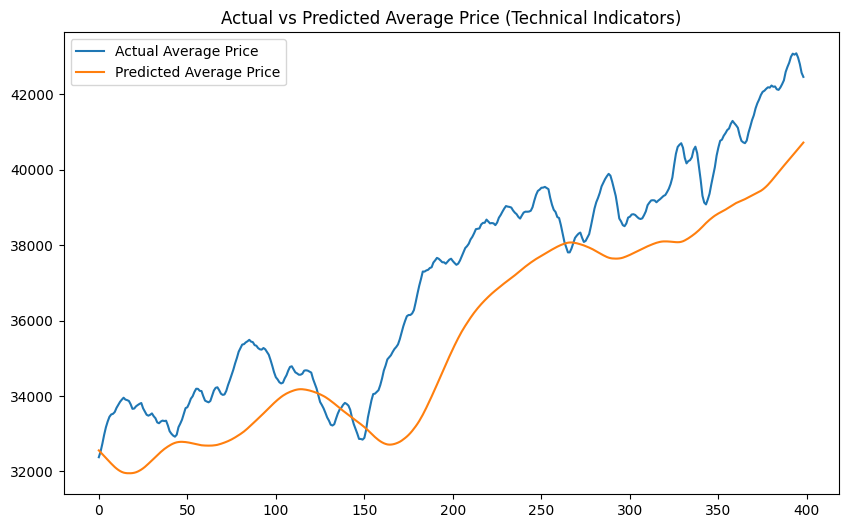

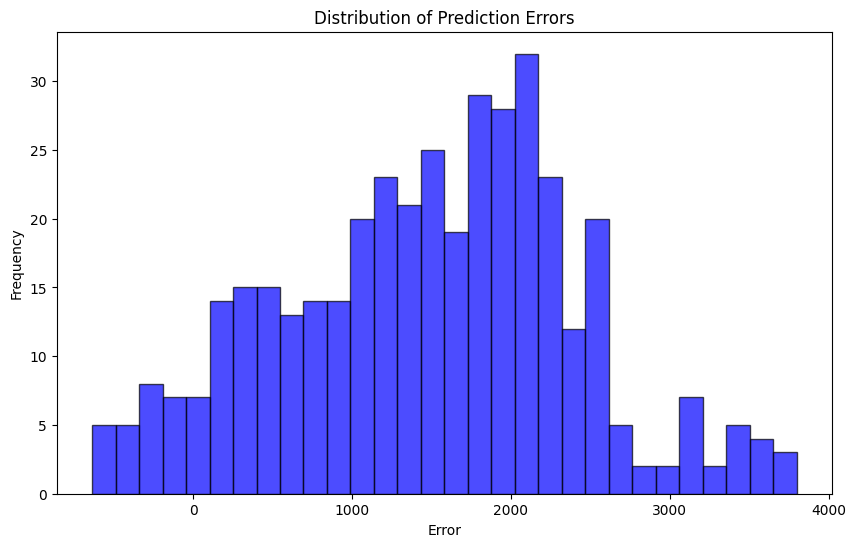

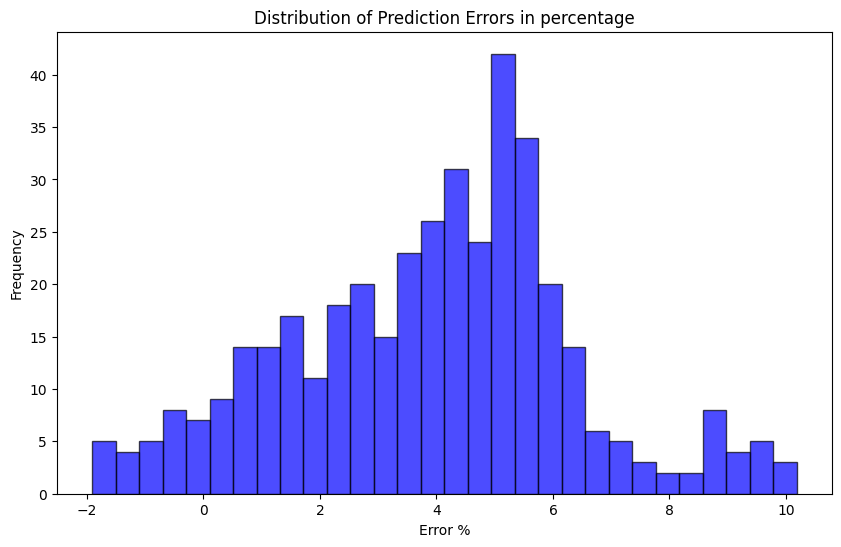

In [50]:
print('----- Create Datasets -----')
# Create datasets
ticker = '^DJI'
start_date = '2015-01-01'
end_date = '2023-01-01'
visualizer = True
features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sequence_length = 30
train_size = 0.7
val_size =0.15
X_train_dji, X_val_dji, X_test_dji, y_train_dji, y_val_dji, y_test_dji = pipeline_data(ticker, start_date, end_date, visualizer, features, sequence_length, train_size, val_size)

# Display shapes for verification
print(f"X_train shape: {X_train_dji.shape}, y_train shape: {y_train_dji.shape}")
print(f"X_val shape: {X_val_dji.shape}, y_val shape: {y_val_dji.shape}")
print(f"X_test shape: {X_test_dji.shape}, y_test shape: {y_test_dji.shape}")

print('----- Model Training -----')
# Parameters for the model
head_size = 128
num_heads = 8
ff_dim = 128
num_trans_blocks = 8
mlp_units = [256, 128, 64, 32]
dropout = 0.1
mlp_dropout = 0.1
attention_axes = None
kernel_size = 1
epsilon = 1e-6
learning_rate_start = 1e-3
learning_rate_stop = 1e-10
patience_lr = 20
patience_es = 50
batch_size = 32
epochs = 200
save_name = 'dji_model.h5'

model_dji, history_dji = model_train(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout,
                                       attention_axes, epsilon, kernel_size, learning_rate_start, learning_rate_stop,
                                       patience_lr, patience_es, batch_size, epochs, save_name, X_train_dji, y_train_dji, X_val_dji, y_val_dji)

plot_learning_curves(history_dji)

print('----- Evaluation -----')
model_eval(model_dji, X_test_dji, y_test_dji)

print('----- Evaluation (Different Period) -----')
# ticker = "^IXIC"
start_date_unseen = "2023-01-01"
end_date_unseen = "2024-10-30"
visualizer_unseen = False
# features = ['RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility'] #['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA_10', 'MA_20', 'MACD', 'KAMA', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
# sequence_length = 30
train_size_unseen = 0
val_size_unseen = 0
model_eval_unseen(model_dji, ticker, start_date_unseen, end_date_unseen, visualizer_unseen, features, sequence_length, train_size_unseen, val_size_unseen)